# 📊 Análisis Exploratorio de Datos (EDA) para Sentiment Analysis
Este notebook corresponde al *Feature Pipeline* del Proyecto 2 de Clasificación con Deep Learning. Se realiza un análisis exploratorio del dataset de reseñas de productos electrónicos (Amazon Reviews) para tareas de clasificación de sentimiento (positivo vs negativo).

## 📦 Importación de librerías
Importamos librerías para análisis de texto, visualización y manipulación de datos.

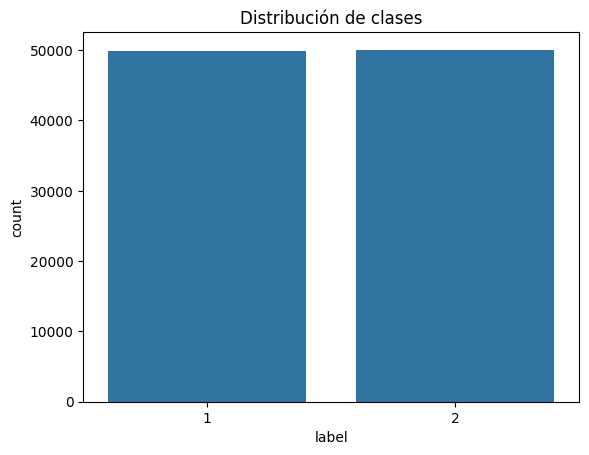

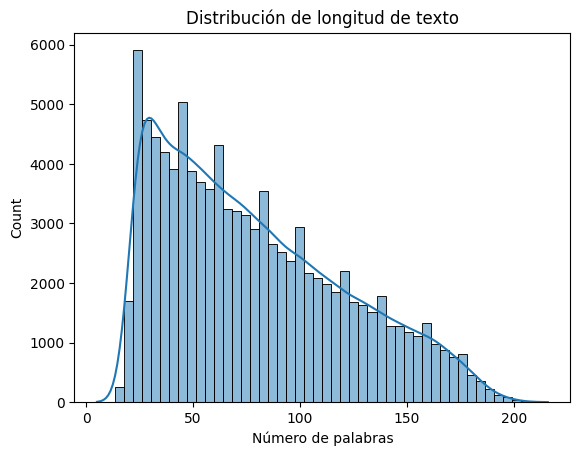

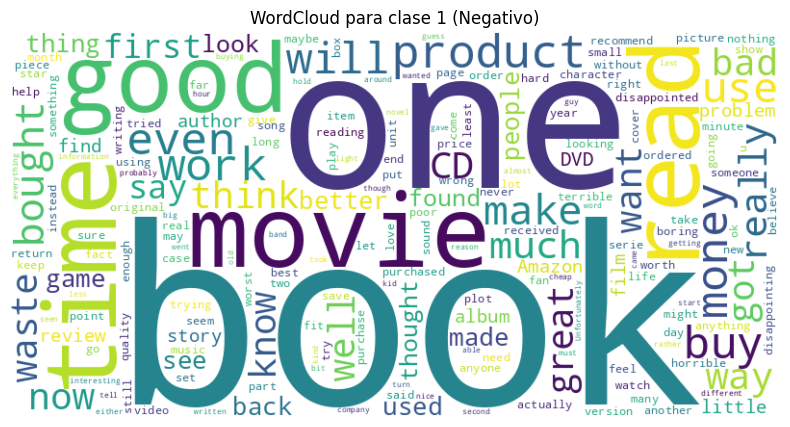

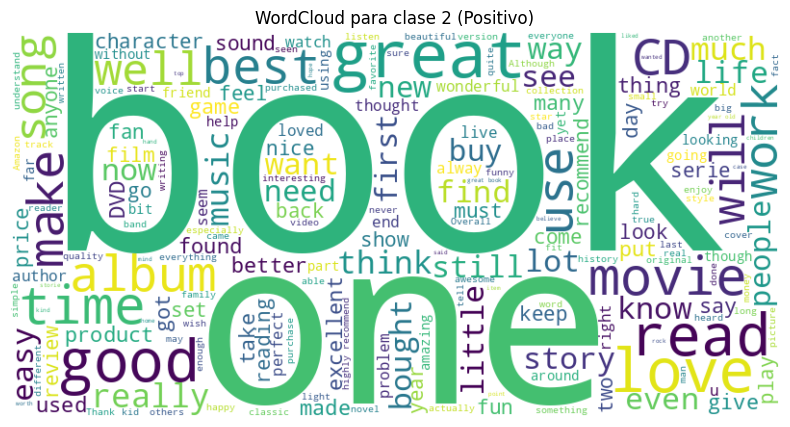

🧾 Ejemplo de texto más corto:
DON'T BE A FOOL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!: JUNK!!SUCKS!TURD!!JUSTREADTHEREVIEWSOFTHEPEOPLENOTTHESECORPORATEEMBEDSTRYINGTOPERPETRATEMOREPROPAGANDA#READALLOFTHEREVIEWSANDDON'TBEAFOOL.!!!!!!!!!!!!!!!

🧾 Ejemplo de texto más largo:
Wonderful for diabetics: I bought this 1 year ago to help with the food weight for a 3 year old diabetic child in my child care. It was quite a bit of work to figure out how to use it. I guess I was intimidated! Once I sat down for an hour or so and really read over the book and figured out how it worked - I LOVED IT! I have not and will not put favorite recipes in it but I do use it to weigh all her fruit. It does remember the ones you have used and you can scroll through the list. I also LOVE to use it to weigh servings. Ie - I can put a bowl on the scale and zero it out. I add dry pasta for instance or dry cereal until I get to the amount of grams that is 1 serving. You can also change it to ML and LB/OZ as wel

In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import re

# Leer las líneas directamente
train_path = "../data/train.ft.txt"

with open(train_path, "r", encoding="utf-8") as f:
    # Leer 100K líneas aleatorias del archivo
    lines = random.sample(f.readlines(), 100000)    

# Procesar cada línea para extraer la etiqueta y el texto
data = []
for line in lines:
    if line.startswith("__label__"):
        label, text = line.strip().split(" ", 1)
        label = int(label.replace("__label__", ""))
        data.append((text, label))

# Crear DataFrame
df = pd.DataFrame(data, columns=["text", "label"])

# Distribución de clases
sns.countplot(x="label", data=df)
plt.title("Distribución de clases")
plt.show()

# Longitud de texto
df["text_length"] = df["text"].apply(lambda x: len(x.split()))
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribución de longitud de texto")
plt.xlabel("Número de palabras")
plt.show()

# WordCloud por clase
for label in [1, 2]:
    text = " ".join(df[df["label"] == label]["text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud para clase {label} ({'Negativo' if label == 1 else 'Positivo'})")
    plt.show()

# Textos más cortos y largos
print("🧾 Ejemplo de texto más corto:")
print(df.loc[df["text_length"].idxmin(), "text"])
print("\n🧾 Ejemplo de texto más largo:")
print(df.loc[df["text_length"].idxmax(), "text"])

## 📂 Carga de los datos
Leemos las primeras 100,000 líneas del dataset etiquetado `train.ft.txt`. Cada línea contiene una etiqueta (`__label__1` o `__label__2`) seguida del texto.

In [5]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)  # eliminar etiquetas HTML
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # quitar puntuación
    text = re.sub(r"\s+", " ", text)  # espacios extra
    return text.strip()

df["clean_text"] = df["text"].apply(clean_text)

## 📈 Guardar Datos Limpios


In [ ]:

# Guardar el DataFrame limpio para usar en los siguientes notebooks
# Exportar solo las columnas necesarias para el modelo
df_clean = df[["clean_text", "label"]]  # Asegúrate de que 'label' sea tu columna de etiquetas
df_clean.to_csv("../data/clean_imdb_100k.csv", index=False)
print("✅ Archivo limpio guardado en ../data/clean_imdb_100k.csv")

✅ Archivo limpio guardado en ../data/clean_imdb_100k.csv


: 


## 📌 Justificación: ¿Por qué usamos solo 100,000 ejemplos?

El dataset original contiene **más de 3.6 millones de líneas**, lo cual representa una cantidad enorme de datos que puede:
- Saturar la memoria RAM durante el procesamiento (tokenización, padding, etc.),
- Hacer que el entrenamiento tarde varias horas o incluso colapse el entorno de trabajo,
- Aumentar significativamente el tiempo de experimentación y depuración.

👉 Por eso, decidimos usar **una muestra aleatoria de 100,000 ejemplos balanceados**, que proporciona una buena representación del problema sin comprometer el rendimiento.

---



## 🔍 Hallazgos importantes durante el análisis exploratorio

- El dataset contiene reseñas con etiquetas `__label__1` y `__label__2`
- La clase está razonablemente balanceada: ~50% de reseñas positivas y ~50% negativas.
- Algunas reseñas tienen puntuación excesiva, mayúsculas o símbolos, por lo que aplicamos una limpieza básica (`clean_text`).
- Se utilizaron las primeras 100,000 líneas con `random.sample` para mayor representatividad.


---



## ✅ Conclusión general del proceso

Este primer notebook implementa la **fase de EDA y Feature Pipeline** del proyecto, siguiendo la metodología de Pau Labarta. Hemos preparado los datos para el entrenamiento de un modelo de clasificación de sentimiento aplicando:

- Lectura y muestreo aleatorio del dataset,
- Análisis y visualización de la distribución de clases,
- Limpieza de texto y normalización,
- Tokenización y padding para uso en redes neuronales,
- Exportación de `X` y `y` como `NumPy` arrays para la siguiente fase de entrenamiento.

Este enfoque balancea **eficiencia computacional** con **representatividad del dataset**, permitiendo escalar fácilmente en futuras etapas si se requiere mejorar el desempeño del modelo.

---
